## 下载数据集

In [2]:
import moxing as mox
# path 最好换成自己的
mox.file.copy_parallel('s3://ai-awe-n4/aifood','./aifood/')
print("done")

INFO:root:Listing OBS: 1000
INFO:root:Listing OBS: 2000
INFO:root:Listing OBS: 3000
INFO:root:Listing OBS: 4000
INFO:root:Listing OBS: 5000
INFO:root:Listing OBS: 6000
INFO:root:Listing OBS: 7000
INFO:root:Listing OBS: 8000
INFO:root:Listing OBS: 9000
INFO:root:Listing OBS: 10000
INFO:root:Listing OBS: 11000
INFO:root:pid: None.	1000/11501
INFO:root:pid: None.	2000/11501
INFO:root:pid: None.	3000/11501
INFO:root:pid: None.	4000/11501
INFO:root:pid: None.	5000/11501
INFO:root:pid: None.	6000/11501
INFO:root:pid: None.	7000/11501
INFO:root:pid: None.	8000/11501
INFO:root:pid: None.	9000/11501
INFO:root:pid: None.	10000/11501
INFO:root:pid: None.	11000/11501


done


## 导包和模型

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import random
import numpy as np

In [9]:
# os.listdir('works')
# 这里我直接把预训练模型加载到了obs
model_names = os.listdir('./')
print(model_names)

['aifood', 'resnet50-19c8e357.pth']


## 加载数据集，并将其分为训练集和测试集

In [12]:
# 手动写一个类来读取数据
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

size = 224
# 使用image net的mean std 简单的数据增强
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer_ImageNet = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    normalize
])
 
val_transformer_ImageNet = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.ToTensor(),
    normalize
])

# 目录文件
data_dir = './aifood/images'
# 为了划分数据集，和自定义transform 所以参考如下链接写了一个这个
# refer https://blog.csdn.net/ncc1995/article/details/91125964
class MyDataset(Dataset):
    def __init__(self, filenames, labels, transform):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
 
    def __len__(self):
        return len(self.filenames)
 
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]

    
def split_Train_Val_Data(data_dir, ratio, bs=64):
    global train_len
    global val_len
    """ the sum of ratio must equal to 1"""
    dataset = ImageFolder(data_dir)     # data_dir精确到分类目录的上一级
    character = [[] for i in range(len(dataset.classes))]
    print(dataset.class_to_idx)
    for x, y in dataset.samples:  # 将数据按类标存放
        character[y].append(x)
#     print(dataset.samples)
    train_inputs, val_inputs, test_inputs = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    for i, data in enumerate(character):   # data为一类图片
        num_sample_train = int(len(data) * ratio[0])
        #print(num_sample_train)
        num_sample_val = int(len(data) * ratio[1])
        num_val_index = num_sample_train + num_sample_val
        # 这里打乱一下数据，实验表明，不打乱也没事
        random.seed(7)
        random.shuffle(data)
        
        for x in data[:num_sample_train]:
            train_inputs.append(str(x))
            train_labels.append(i)
        for x in data[num_sample_train:num_val_index]:
            val_inputs.append(str(x))
            val_labels.append(i)
    
    train_len = len(train_inputs)
    val_len = len(val_inputs)
    print("train_length:%d,val length:%d" %(train_len,val_len))
    
    train_dst = MyDataset(train_inputs, train_labels, train_transformer_ImageNet)
    valid_dst = MyDataset(val_inputs, val_labels, val_transformer_ImageNet)
    train_dataloader = DataLoader(train_dst,
                                  batch_size=bs, shuffle=True)
    val_dataloader = DataLoader(valid_dst,
                                  batch_size=bs, shuffle=False)
 
    return train_dataloader, val_dataloader

# 定义pytorch的dataloader，数据划分0.9 可以提升一个点左右
data_loader = split_Train_Val_Data(data_dir,(0.9,0.1))

{'三明治': 0, '冰激凌': 1, '土豆泥': 2, '小米粥': 3, '松鼠鱼': 4, '烤冷面': 5, '玉米饼': 6, '甜甜圈': 7, '芒果班戟': 8, '鸡蛋布丁': 9}
train_length:4500,val length:500


In [13]:
# 为了保证后面和官方的baseline一致，所以可以这么写
dataloders = {x:  data_loader[i] for i,x in enumerate(['train', 'val']) }
dataset_sizes = {'train':train_len, 'val':val_len}
print(dataset_sizes)
# use gpu or not
use_gpu = torch.cuda.is_available()

{'train': 4500, 'val': 500}


In [14]:
# 这里计算了一下所有照片的均值，方差，可以酌情替换imageNet 的
# mean std = [0.6736, 0.5654, 0.4031],[0.1994, 0.2248, 0.2528]

## 训练网络

In [15]:
def train_model(model, lossfunc, optimizer, scheduler, num_epochs=10):
    start_time = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_acc = []
    valid_acc = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 
                model.train(True)  # Set model to training mode
            else:
                
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data
                

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = lossfunc(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
                valid_acc.append(epoch_acc)
            else:
                train_acc.append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        # 这里使用了学习率调整策略
        scheduler.step(valid_acc[-1])
    elapsed_time = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
  
    return model,train_acc,valid_acc

In [16]:
# 之前手写的标签平滑可以直接用，也可以不用。
import torch.nn as nn
import torch.nn.functional as F
import torch

# export label smoothing
from torch.autograd import Variable

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

def lin_comb(a, b, epsilon):
    return epsilon * a + b * (1 - epsilon)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon, self.reduction = epsilon, reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss / c, nll, self.epsilon)

## 模型训练

In [17]:
# 这里模型选择比较短的resnet50跑起来比较快
model_ft = models.resnet50(pretrained=False)
# 训练权重我自己下载的，然后拷贝到了notebook目录下面
model_ft.load_state_dict(torch.load('./resnet50-19c8e357.pth'))
num_ftrs = model_ft.fc.in_features
# 可以如下在全连接层前面加入dropout来防止过拟合
# model_ft.fc = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(2048, 10)
# )
model_ft.fc=nn.Linear(num_ftrs, 10)
if use_gpu:
    model_ft = model_ft.cuda()

# define loss function
lossfunc = nn.CrossEntropyLoss()
# lossfunc = LabelSmoothingCrossEntropy()

# 这里直接训练整个网络，也可以像原来baseline先fc后解冻整个网络
parameters = list(model_ft.parameters())
optimizer_ft = optim.SGD(parameters, lr=0.001, momentum=0.9, nesterov=True)

# 使用ReduceLROnPlateau学习调度器，如果三个epoch准确率没有提升，则减少学习率
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft,mode='max',patience=3,verbose=True)
model_ft,train_acc,valid_acc = train_model(model=model_ft,
                           lossfunc=lossfunc,
                           optimizer=optimizer_ft,
                           scheduler=exp_lr_scheduler,
                           num_epochs=20)

Epoch 0/19
----------
train Loss: 0.0218 Acc: 0.6553
val Loss: 0.0091 Acc: 0.8760
Epoch 1/19
----------
train Loss: 0.0065 Acc: 0.8893
val Loss: 0.0048 Acc: 0.9160
Epoch 2/19
----------
train Loss: 0.0042 Acc: 0.9213
val Loss: 0.0035 Acc: 0.9380
Epoch 3/19
----------
train Loss: 0.0029 Acc: 0.9480
val Loss: 0.0031 Acc: 0.9420
Epoch 4/19
----------
train Loss: 0.0022 Acc: 0.9633
val Loss: 0.0026 Acc: 0.9480
Epoch 5/19
----------
train Loss: 0.0019 Acc: 0.9691
val Loss: 0.0024 Acc: 0.9580
Epoch 6/19
----------
train Loss: 0.0014 Acc: 0.9787
val Loss: 0.0022 Acc: 0.9520
Epoch 7/19
----------
train Loss: 0.0012 Acc: 0.9833
val Loss: 0.0022 Acc: 0.9560
Epoch 8/19
----------
train Loss: 0.0009 Acc: 0.9871
val Loss: 0.0020 Acc: 0.9580
Epoch 9/19
----------
train Loss: 0.0007 Acc: 0.9911
val Loss: 0.0020 Acc: 0.9640
Epoch 10/19
----------
train Loss: 0.0007 Acc: 0.9924
val Loss: 0.0018 Acc: 0.9580
Epoch 11/19
----------
train Loss: 0.0006 Acc: 0.9931
val Loss: 0.0018 Acc: 0.9660
Epoch 12/19
--

INFO:matplotlib.font_manager:font search path ['/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/afm', '/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
INFO:matplotlib.font_manager:generated new fontManager


[]

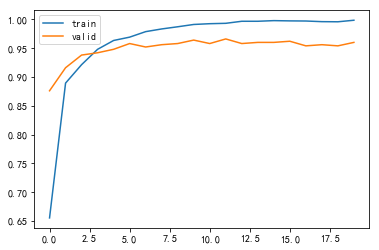

In [18]:
# acc 曲线
# best = 9540
%matplotlib inline
import matplotlib.pylab as plt
plt.plot(train_acc,label="train")
plt.plot(valid_acc,label='valid')
plt.legend()
plt.plot()

## 保存

In [19]:
torch.save(model_ft.state_dict(), './model.pth')

In [20]:
import moxing as mox
# 注意拷贝到自己的目录环境下面即可
mox.file.copy('./model.pth','s3://ai-awe-n4/model_god/model/resnet-50.pth')
print("done")

done


## 推理

In [21]:
# 修改里面的网络定义函数resnet50即可,接口通常修改为和val的tansform一致
mean,std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
infer_transformation = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

def resnet50(model_path, **kwargs):

    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = models.resnet34(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model.load_state_dict(torch.load(model_path,map_location ='cpu'))

    model.eval()

    return model